# 🔴 **Environment Setup**

## 🟠 Install Libraries

In [ ]:
!pip install -q portalocker>=2.0.0
!pip install -q torchmetrics
!pip install wandb

# 🔴 **Import Libs**

In [ ]:
import os
from glob import glob
import random
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
from PIL import Image
import cv2

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import io
from torchvision.transforms import v2
import torchvision.transforms.functional as F
from torchvision.datasets import VisionDataset
from torchvision import tv_tensors
from torchvision.utils import make_grid

import torchtext
from torchtext.vocab import build_vocab_from_iterator

import tqdm
import torchmetrics as tm
from torchmetrics import MeanMetric

# 🔴 **Utils**

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False


In [ ]:
def time_for_each_batch(loader):
  start = time.time()
  for iter, (img, mask) in enumerate(loader, 1):
    continue
  end = time.time()
  total_time = end - start
  return total_time, total_time/len(loader)

# 🔴 **Arguments**

In [ ]:
seed = 8
wandb_enable = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

root = Path('data/v0.3/processed/')

batch_size = 10

In [ ]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


# 🔴 **Dataset**

## 🟠 Create Dataset!

## 🟠 Load a Sample Data

In [ ]:
root / 'train' / 'metadata.csv'

WindowsPath('data/v0.3/processed/train/metadata.csv')

In [ ]:
df = pd.read_csv(root / 'train' / 'metadata.csv')
display(df.head())
df.shape

,input,target,hair,shirt
0,0001.bmp,0001.bmp,blue,blue
1,0001.bmp,0002.bmp,blue,brown
2,0001.bmp,0003.bmp,blue,red
3,0001.bmp,0004.bmp,blue,yellow
4,0001.bmp,0005.bmp,blue,green


(250, 4)

Hair: blue, Shirt: red


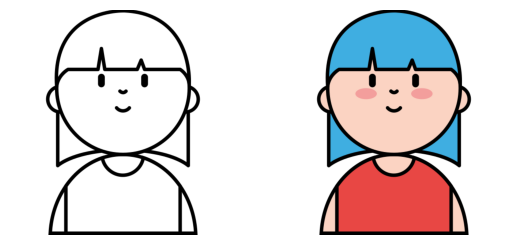

In [ ]:
idx = random.randint(0, df.shape[0])
sample = df.iloc[idx]

# root / 'train/inputs' / sample['input']
# str(root / 'train/inputs' / sample['input'])
src = cv2.imread(str(root / 'train/inputs' / sample['input']))
tgt = cv2.imread(str(root / 'train/targets' / sample['target']))
tgt = cv2.cvtColor(tgt, cv2.COLOR_BGR2RGB)

print(f"Hair: {sample['hair']}, Shirt: {sample['shirt']}")

fig, axes = plt.subplots(1, 2)
axes[0].imshow(src)
axes[0].axis('off')
axes[1].imshow(tgt)
axes[1].axis('off');

## 🟠 Work with Text Conditions

In [ ]:
conditions = df['hair'].tolist()
print(conditions)

['blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'brown', 'brown', 'brown', 'brown', 'brown', 'red', 'red', 'red', 'red', 'red', 'yellow', 'yellow',

In [ ]:
vocab = build_vocab_from_iterator([conditions])
vocab.get_stoi()

{'blue': 0, 'brown': 1, 'red': 3, 'green': 2, 'yellow': 4}

In [ ]:
embeds = torch.eye(len(vocab))

hair_idx, shirt_idx = vocab[sample['hair']], vocab[sample['shirt']]

embeds[hair_idx], embeds[shirt_idx]

(tensor([1., 0., 0., 0., 0.]), tensor([0., 0., 0., 1., 0.]))

## 🟠 EDA

## 🟠 Custom dataset

In [ ]:
class ImageTranslationDataset(VisionDataset):

  def __init__(self, root: str,
               transforms: Optional[Callable] = None,
               memory: bool = False):

    super().__init__(root, transforms=transforms)

    self.input_folder = root / 'inputs'
    self.target_folder = root / 'targets'

    self.df = pd.read_csv(root / 'metadata.csv')
    metadata = self.df['hair'].tolist()
    self.vocab = build_vocab_from_iterator([metadata])
    self.embeds = torch.eye(len(self.vocab))

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    #
    sample = self.df.iloc[idx]

    input_image = self._load_image(self.input_folder / sample['input'])
    target_image = self._load_image(self.target_folder / sample['target'])

    hair, shirt = sample['hair'], sample['shirt']
    condition = self.embeds[[self.vocab[hair], self.vocab[shirt]]]
    condition = condition.view(-1, 1, 1)

    input_image, target_image = self.transforms(input_image, target_image)

    return input_image, target_image, condition

  def _load_image(self, path):
    img = Image.open(path)
    return tv_tensors.Image(img)

  def __repr__(self):
    return f'Number of datapoints: {self.__len__()}'


### 🟡 Final

In [ ]:
transform_train = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    ])

transform_valid = v2.Compose([
    v2.Resize(size=(256, 256), antialias=True),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    ])

In [ ]:
train_set = ImageTranslationDataset(root / 'train', transform_train)
valid_set = ImageTranslationDataset(root / 'test', transform_valid)
train_set, valid_set

(Number of datapoints: 250, Number of datapoints: 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 1])


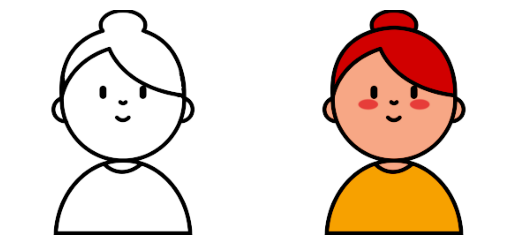

In [ ]:
idx = random.randint(0, len(train_set)-1)
src, tgt, vecs = train_set[idx]

fig, axes = plt.subplots(1, 2)
axes[0].imshow(src.permute(1, 2, 0)), axes[0].axis('off')
axes[1].imshow(tgt.permute(1, 2, 0)), axes[1].axis('off');

print(vecs.shape)

## 🟠 Dataloader

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [ ]:
imgs, tgts, txts = next(iter(train_loader))
imgs.shape, tgts.shape, txts.shape

(torch.Size([10, 3, 256, 256]),
 torch.Size([10, 3, 256, 256]),
 torch.Size([10, 10, 1, 1]))

In [ ]:
imgs, tgts, txts = next(iter(valid_loader))
imgs.shape, tgts.shape, txts.shape

(torch.Size([10, 3, 256, 256]),
 torch.Size([10, 3, 256, 256]),
 torch.Size([10, 10, 1, 1]))

# 🔴 **Model**

## 🟠 Generator

### 🟡 Encoder block

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=4, batchnorm=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels) if batchnorm else None
    self.af = nn.LeakyReLU(0.2, inplace=True)

  def forward(self, x):
    x = self.conv(x)
    if self.bn:
      x = self.bn(x)
    x = self.af(x)
    return x

In [ ]:
encoder_block = EncoderBlock(in_channels=3, out_channels=64, kernel_size=4, batchnorm=True)
with torch.no_grad():
  tmp = encoder_block(torch.randn(1, 3, 256, 256))
tmp.shape

torch.Size([1, 64, 128, 128])

### 🟡 Decoder block

In [ ]:
class DecoderBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=4, dropout=False):
    super().__init__()
    self.tconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)
    self.dropout = nn.Dropout(0.5) if dropout else None
    self.af = nn.ReLU()

  def forward(self, x):
    x = self.tconv(x)
    x = self.bn(x)
    if self.dropout:
      x = self.dropout(x)
    x = self.af(x)
    return x

In [ ]:
decoder_block = DecoderBlock(in_channels=512, out_channels=256, dropout=False)
tmp = decoder_block(torch.randn(2, 512, 4, 4))
tmp.shape

torch.Size([2, 256, 8, 8])

### 🟡 U-Net

In [ ]:
class Generator(nn.Module):

  def __init__(self, in_channels=13):
    super().__init__()

    # Encoder
    # self.encoders = nn.ModuleList([
    #     EncoderBlock(3, 64, kernel_size=4, batchnorm=False),
    #     EncoderBlock(64, 128, kernel_size=4, batchnorm=True),
    #     EncoderBlock(128, 256, kernel_size=4, batchnorm=True),
    #     EncoderBlock(256, 512, kernel_size=4, batchnorm=True),
    #     EncoderBlock(512, 512, kernel_size=4, batchnorm=True),
    #     EncoderBlock(512, 512, kernel_size=4, batchnorm=True),
    #     EncoderBlock(512, 512, kernel_size=4, batchnorm=True),
    #     EncoderBlock(512, 512, kernel_size=4, batchnorm=True),
    #     ])
    nc = [in_channels, 64, 128, 256, 512, 512, 512, 512, 512]
    self.encoders = nn.ModuleList([
        EncoderBlock(nc[i-1], nc[i], batchnorm=False if i==1 else True) for i in range(1, len(nc))
    ])

    # Decoder
    # self.decoders = nn.ModuleList([
    #     DecoderBlock(512, 512, kernel_size=4, dropout=True),
    #     DecoderBlock(512, 512, kernel_size=4, dropout=True),
    #     DecoderBlock(512, 512, kernel_size=4, dropout=True),
    #     DecoderBlock(512, 512, kernel_size=4, dropout=False),
    #     DecoderBlock(512, 256, kernel_size=4, dropout=False),
    #     DecoderBlock(256, 128, kernel_size=4, dropout=False),
    #     DecoderBlock(128, 64, kernel_size=4, dropout=False)
    #     ])
    nc.reverse()
    self.decoders = nn.ModuleList([
        DecoderBlock(2*nc[i-1] if i>1 else nc[i-1], nc[i], dropout=True if i<4 else False) for i in range(1, len(nc[:-1]))
    ])

    self.last = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)
    self.tanh = nn.Tanh()

  def forward(self, x, c):
    # Concat
    _, _, h, w = x.shape
    c = c.repeat(1, 1, h, w)
    x = torch.cat((x, c), dim=1)

    # Encoder
    skips = []
    for encoder in self.encoders:
      x = encoder(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    # Decoder
    for decoder, skip in zip(self.decoders, skips):
      x = decoder(x)
      x = torch.cat((x, skip), 1)

    out = self.last(x)
    out = self.tanh(out)

    return out

In [ ]:
generator = Generator(in_channels=13)
tmp = generator(torch.randn(2, 3, 256, 256), torch.randn(2, 10, 1, 1))
tmp.shape

torch.Size([2, 3, 256, 256])

In [ ]:
generator

Generator(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): Conv2d(13, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): EncoderBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): EncoderBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): EncoderBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (af): LeakyReLU(negative_sl

## 🟠 Discriminator

### 🟡 Basic block

In [ ]:
class BasicBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=4, batchnorm=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels) if batchnorm else None
    self.af = nn.LeakyReLU(0.2, inplace=True)

  def forward(self, x):
    x = self.conv(x)
    if self.bn:
      x = self.bn(x)
    x = self.af(x)
    return x

In [ ]:
basic_block = BasicBlock(in_channels=3, out_channels=64, kernel_size=4, batchnorm=True)
with torch.no_grad():
  tmp = basic_block(torch.randn(1, 3, 256, 256))
tmp.shape

torch.Size([1, 64, 128, 128])

### 🟡 Main network

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, in_channels=16):
    super().__init__()
    nc = [in_channels, 64, 128, 256]
    self.layers = nn.ModuleList([
        EncoderBlock(nc[i-1], nc[i], batchnorm=True if i>1 else False) for i in range(1, len(nc))
    ])

    self.layers += nn.Sequential(
        nn.ZeroPad2d(padding=1),
        nn.Conv2d(256, 512, kernel_size=4, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2))

    self.layers += nn.Sequential(
        nn.ZeroPad2d(1),
        nn.Conv2d(512, 1, kernel_size=4)
    )

  def forward(self, x, y, c):
    # Concat
    _, _, h, w = x.shape
    c = c.repeat(1, 1, h, w)
    x = torch.cat((x, y, c), dim=1)

    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
discriminator = Discriminator(in_channels=16)
tmp = discriminator(torch.randn(2, 3, 256, 256), torch.randn(2, 3, 256, 256), torch.randn(2, 10, 1, 1))
tmp.shape

torch.Size([2, 1, 30, 30])

## 🟠 Final

In [ ]:
generator = Generator(in_channels=13)
discriminator = Discriminator(in_channels=16)

# 🔴 **Config**

## 🟠 Loss

### 🟡 Generator

In [ ]:
class GeneratorLoss(nn.Module):

  def __init__(self, LAMBDA=100):
    super().__init__()
    self.LAMBDA = LAMBDA
    self.l1 = nn.L1Loss()
    self.bce = nn.BCEWithLogitsLoss()

  def forward(self, disc_generated_output, gen_output, target):
    l1_loss = self.l1(gen_output, target)

    all_ones = torch.ones_like(disc_generated_output)
    gan_loss = self.bce(disc_generated_output, all_ones)

    total_gan_loss = gan_loss + self.LAMBDA * l1_loss

    return total_gan_loss

In [ ]:
loss_g = GeneratorLoss(LAMBDA=100)
loss_g

GeneratorLoss(
  (l1): L1Loss()
  (bce): BCEWithLogitsLoss()
)

### 🟡 Discriminator

In [ ]:
class DiscriminatorLoss(nn.Module):

  def __init__(self):
    super().__init__()
    self.bce = nn.BCEWithLogitsLoss()

  def forward(self, disc_real_output, disc_generated_output):
    all_ones = torch.ones_like(disc_real_output)
    real_loss = self.bce(disc_real_output, all_ones)

    all_zeros = torch.zeros_like(disc_generated_output)
    generated_loss = self.bce(disc_generated_output, all_zeros)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
loss_d = DiscriminatorLoss()
loss_d

DiscriminatorLoss(
  (bce): BCEWithLogitsLoss()
)

## 🟠 Optimizer

In [ ]:
optimizer_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# 🔴 **Train ➰**

## 🟠 Train Function

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(generator, discriminator,
                    train_loader,
                    generator_loss_fn, discriminator_loss_fn,
                    generator_optimizer, discriminator_optimizer,
                    epoch=None):

  generator.train()
  discriminator.train()

  gen_total_loss, disc_total_loss = MeanMetric(), MeanMetric()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets, conditions in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)
      conditions = conditions.to(device)

      # Generator's loss
      gen_outputs = generator(inputs, conditions)
      disc_gen_outputs = discriminator(inputs, gen_outputs, conditions)
      gen_loss = generator_loss_fn(disc_gen_outputs, gen_outputs, targets)

      # Discriminator's loss
      # with torch.no_grad():
      #   gen_outputs = generator(inputs, conditions)
      # gen_outputs = gen_outputs.detach()
      gen_outputs = generator(inputs, conditions).detach()
      disc_gen_outputs = discriminator(inputs, gen_outputs, conditions)
      disc_real_outputs = discriminator(inputs, targets, conditions)
      disc_loss = discriminator_loss_fn(disc_real_outputs, disc_gen_outputs)

      # Generator's params update
      generator_optimizer.zero_grad()
      gen_loss.backward()
      generator_optimizer.step()

      # Discriminator's params update
      discriminator_optimizer.zero_grad()
      disc_loss.backward()
      discriminator_optimizer.step()

      gen_total_loss.update(gen_loss.item(), weight=len(inputs))
      disc_total_loss.update(disc_loss.item(), weight=len(inputs))

      tepoch.set_postfix(
          lossG=gen_total_loss.compute().item(),
          lossD=disc_total_loss.compute().item()
          )

  return gen_total_loss.compute().item(), disc_total_loss.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(generator, test_loader, loss_fn):

  loss_eval = MeanMetric()

  with torch.inference_mode():
    for inputs, targets, conditions in test_loader:

      inputs = inputs.to(device)
      targets = targets.to(device)
      conditions = conditions.to(device)

      outputs = generator(inputs, conditions)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), weight=len(targets))

  return loss_eval.compute().item()

# 🔴 **Generate**

In [ ]:
def generate(generator, valid_loader, filename='img.png'):

  inputs, targets, conditions = next(iter(valid_loader))
  inputs = inputs.to(device)
  conditions = conditions.to(device)

  with torch.inference_mode():
    outputs = generator(inputs, conditions)

  outputs = (255*(0.5*outputs + 0.5)).byte().cpu()
  targets = (255*(0.5*targets + 0.5)).byte().cpu()

  imgs = [t for t in targets] + [o for o in outputs]
  grid = make_grid(imgs, nrow=10)

  io.write_png(grid, filename)

In [ ]:
generate(generator.cuda(), valid_loader)

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model =

inputs, targets = next(iter(train_set))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model =
optimizer = torch.optim.SGD(model.parameters(), lr=, momentum=0.9)

In [ ]:
num_epochs = ...
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, ..., loss_fn, optimizer, metric, epoch)

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs =

for lr in [...]:
  print(f'LR={lr}')

  model =
  optimizer =

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_set, loss_fn, optimizer, metric, epoch)

  print()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs =

for lr in [...]:
  for wd in [...]:
    print(f'LR={lr}, WD={wd}')

    model =
    optimizer =

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer =

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 Define model.

In [ ]:
set_seed(seed)

generator = Generator(in_channels=13).to(device)
discriminator = Discriminator(in_channels=16).to(device)

🔰 Define loss functions.

In [ ]:
gen_loss_fn = GeneratorLoss(LAMBDA=100)
disc_loss_fn = DiscriminatorLoss()

🔰 Define optimizers and Set learning rate and weight decay.

In [ ]:
set_seed(seed)

lr = 0.0002
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_gen_hist = []
loss_disc_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 50
generate(generator, valid_loader, f'results/img-0.png')

for epoch in range(num_epochs):
  # Train
  gen_loss, disc_loss = train_one_epoch(
      generator, discriminator,
      train_loader,
      gen_loss_fn, disc_loss_fn,
      gen_optimizer, disc_optimizer,
      epoch+1)

  # Validation
  loss_valid = evaluate(
      generator,
      valid_loader,
      nn.MSELoss())

  generate(generator, valid_loader, f'results/img-{epoch+1}.png')

  loss_gen_hist.append(gen_loss)
  loss_disc_hist.append(disc_loss)
  loss_valid_hist.append(loss_valid)

  if loss_valid < best_loss_valid:
    torch.save(generator, f'weights/generator-best.pt')
    best_loss_valid = loss_valid
    print('Generator Saved!')

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  # if wandb_enable:
  #   wandb.log({"metric_train": metric_train, "loss_train": loss_train,
  #               "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

torch.save(generator, f'generator-last.pt')

## 🟠 Plot

🔰 Plot learning curves

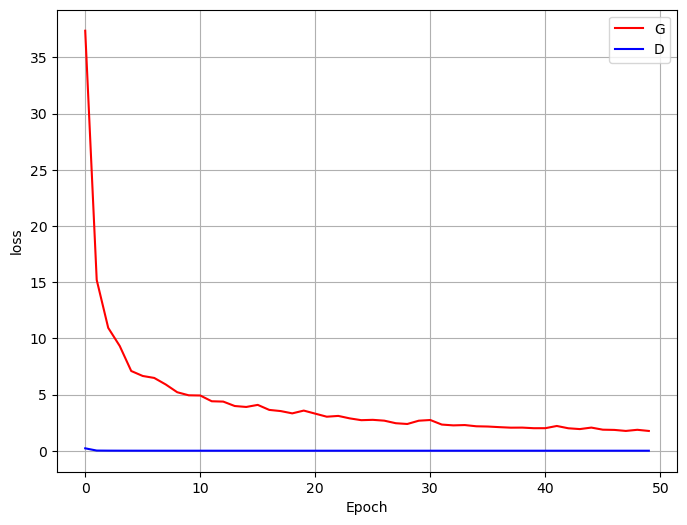

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_gen_hist, 'r-', label='G')
plt.plot(range(epoch_counter), loss_disc_hist, 'b-', label='D')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()